In [2]:
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
tqdm.pandas()


Sentiment Analysis

In [3]:
# Absolute path to the input CSV
RAW_IN = r"C:\Users\h\Desktop\WEEK 2\Web-Scraping\data\processed\reviews_processed.csv"

# Absolute or relative path for output CSV
OUT_CSV = r"C:\Users\h\Desktop\WEEK 2\Web-Scraping\data\processed\reviews_with_sentiment_themes.csv"

df = pd.read_csv(RAW_IN)
df

,review_id,review_text,rating,review_date,review_year,review_month,bank_code,bank_name,user_name,thumbs_up,text_length,source
0,3463230e-f9f7-4be3-a632-fdd8d017ce84,🙏👍,5,2025-11-29,2025,11,BOA,Bank of Abyssinia,Yasin Alemu,0,2,Google Play
1,a6cbfa34-f2b1-4a16-96b6-c94f58cea76f,Very Good,5,2025-11-28,2025,11,BOA,Bank of Abyssinia,Wariyo Dida,0,9,Google Play
2,fc67d12c-92e2-45aa-a9e0-011f58a583bc,goof,5,2025-11-28,2025,11,BOA,Bank of Abyssinia,Hailegebrail Tegegn,0,4,Google Play
3,11306fb9-5571-4950-8d32-604c5402242f,good!,5,2025-11-28,2025,11,BOA,Bank of Abyssinia,Tsegay ab,0,5,Google Play
4,809c46d2-730e-446a-9061-2a45e978ad9d,good jop,5,2025-11-27,2025,11,BOA,Bank of Abyssinia,Yohanis Fikadu,0,8,Google Play
...,...,...,...,...,...,...,...,...,...,...,...,...
1038,c3afc51f-9e2b-4b3d-b155-0339a9ce0f20,"A must have, seamless, all in one digital plat...",5,2025-05-12,2025,5,Dashenbank,Dashen Bank,Temesgen Mehari,2,112,Google Play
1039,e1c1214a-8bc1-45db-bc49-3d51dddc6b88,Amazing app super easy to use and best design....,5,2025-05-09,2025,5,Dashenbank,Dashen Bank,Yitbarek Gossaye,1,56,Google Play
1040,8d1d472b-2bae-4749-b089-5632108ade02,its the best ever,5,2025-05-09,2025,5,Dashenbank,Dashen Bank,natnael abera,1,17,Google Play
1041,f2852962-b983-44af-b296-241a3373477f,excellent game changer App,5,2025-05-08,2025,5,Dashenbank,Dashen Bank,Wondim Tarko,1,26,Google Play


In [4]:
# Load transformer-based sentiment pipeline
from transformers import pipeline

sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english"
)

def score_sentiment_transformer(text: str):
    """
    Compute sentiment label and score using a transformer model.
    Returns label ('positive'/'negative') and score (0-1 confidence).
    """
    result = sentiment_pipeline(str(text))  # returns list of dicts
    label = result[0]['label'].lower()      # 'POSITIVE' -> 'positive'
    score = result[0]['score']              # confidence score
    return pd.Series({"sentiment_score": score, "sentiment_label": label})



c:\Users\h\Desktop\WEEK 2\Web-Scraping\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use cpu


In [6]:
# VADER ANALYSER
analyzer = SentimentIntensityAnalyzer()

def score_sentiment(text: str):
    """
    Compute sentiment label and compound score using VADER.
    Returns positive/negative/neutral label.
    """
    s = analyzer.polarity_scores(str(text))
    if s["compound"] >= 0.05:
        label = "positive"
    elif s["compound"] <= -0.05:
        label = "negative"
    else:
        label = "neutral"
    return pd.Series({"sentiment_compound": s["compound"], "sentiment_label": label})

Thematic Analysis

In [7]:
def extract_keywords(docs, top_n=10):
    """
    Extract top TF-IDF keywords from a list of documents
    """
    vect = TfidfVectorizer(ngram_range=(1,2), stop_words='english', max_features=5000)
    X = vect.fit_transform(docs)
    features = vect.get_feature_names_out()
    avg_tfidf = np.asarray(X.mean(axis=0)).ravel()
    top_idx = np.argsort(avg_tfidf)[::-1][:top_n]
    return [features[i] for i in top_idx]

In [8]:
def cluster_themes(docs, n_clusters=4):
    """
    Cluster reviews using TF-IDF + KMeans
    Returns cluster labels and top keywords per cluster
    """
    vect = TfidfVectorizer(ngram_range=(1,2), stop_words='english', max_features=5000)
    X = vect.fit_transform(docs)
    model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = model.fit_predict(X)
    
    terms = vect.get_feature_names_out()
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    cluster_keywords = {}
    
    for i in range(n_clusters):
        top_terms = [terms[ind] for ind in order_centroids[i, :10]]
        cluster_keywords[i] = top_terms
    return labels, cluster_keywords

Human Readable Theme Naming

In [9]:
def assign_theme_names(cluster_keywords):
    """
    Map clusters to human-readable themes based on top keywords
    """
    theme_map = {}
    for cid, keywords in cluster_keywords.items():
        keywords_lower = [k.lower() for k in keywords]
        if any(word in keywords_lower for word in ["login", "password", "access"]):
            theme_map[cid] = "Account Access Issues"
        elif any(word in keywords_lower for word in ["slow", "loading", "lag", "speed", "transfer"]):
            theme_map[cid] = "Transaction Performance"
        elif any(word in keywords_lower for word in ["ui", "design", "interface", "screen"]):
            theme_map[cid] = "User Interface & Experience"
        elif any(word in keywords_lower for word in ["support", "help", "customer"]):
            theme_map[cid] = "Customer Support"
        elif any(word in keywords_lower for word in ["feature", "request", "fingerprint"]):
            theme_map[cid] = "Feature Requests"
        else:
            theme_map[cid] = "Other"
    return theme_map

In [21]:
# Run main Analysis
def run_analysis(input_csv=RAW_IN, output_csv=OUT_CSV, n_clusters=4):
    df = pd.read_csv(input_csv)
    
    # --- Sentiment using VADER --- 
    df[["sentiment_compound", "sentiment_label"]] = df["review_text"].progress_apply(score_sentiment)

    # --- Sentiment using Transformer ---
    # df[["sentiment_score", "sentiment_label"]] = df["review"].progress_apply(score_sentiment_transformer)

    
    # --- Themes ---
    theme_labels = []
    
    for bank in df['bank_name'].unique():
        bank_mask = df['bank_name'] == bank
        docs = df.loc[bank_mask, "review_text"].astype(str).tolist()
        if len(docs) == 0:
            continue
        
        labels, cluster_keywords = cluster_themes(docs, n_clusters=n_clusters)
        cluster_map = assign_theme_names(cluster_keywords)
        df.loc[bank_mask, "theme_label"] = [cluster_map[lbl] for lbl in labels]
    
    # --- Save ---
    os.makedirs(os.path.dirname(output_csv), exist_ok=True)
    df.to_csv(output_csv, index=False)
    print(f"Saved annotated reviews with sentiment & themes -> {output_csv}")
    return df

In [23]:
df_final = run_analysis()
df_final

100%|██████████| 1043/1043 [00:00<00:00, 1664.18it/s]


Saved annotated reviews with sentiment & themes -> C:\Users\h\Desktop\WEEK 2\Web-Scraping\data\processed\reviews_with_sentiment_themes.csv


,review_id,review_text,rating,review_date,review_year,review_month,bank_code,bank_name,user_name,thumbs_up,text_length,source,sentiment_compound,sentiment_label,theme_label
0,3463230e-f9f7-4be3-a632-fdd8d017ce84,🙏👍,5,2025-11-29,2025,11,BOA,Bank of Abyssinia,Yasin Alemu,0,2,Google Play,0.0000,neutral,Other
1,a6cbfa34-f2b1-4a16-96b6-c94f58cea76f,Very Good,5,2025-11-28,2025,11,BOA,Bank of Abyssinia,Wariyo Dida,0,9,Google Play,0.4927,positive,Other
2,fc67d12c-92e2-45aa-a9e0-011f58a583bc,goof,5,2025-11-28,2025,11,BOA,Bank of Abyssinia,Hailegebrail Tegegn,0,4,Google Play,0.0000,neutral,Other
3,11306fb9-5571-4950-8d32-604c5402242f,good!,5,2025-11-28,2025,11,BOA,Bank of Abyssinia,Tsegay ab,0,5,Google Play,0.4926,positive,Other
4,809c46d2-730e-446a-9061-2a45e978ad9d,good jop,5,2025-11-27,2025,11,BOA,Bank of Abyssinia,Yohanis Fikadu,0,8,Google Play,0.4404,positive,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1038,c3afc51f-9e2b-4b3d-b155-0339a9ce0f20,"A must have, seamless, all in one digital plat...",5,2025-05-12,2025,5,Dashenbank,Dashen Bank,Temesgen Mehari,2,112,Google Play,0.0000,neutral,Other
1039,e1c1214a-8bc1-45db-bc49-3d51dddc6b88,Amazing app super easy to use and best design....,5,2025-05-09,2025,5,Dashenbank,Dashen Bank,Yitbarek Gossaye,1,56,Google Play,0.9623,positive,Transaction Performance
1040,8d1d472b-2bae-4749-b089-5632108ade02,its the best ever,5,2025-05-09,2025,5,Dashenbank,Dashen Bank,natnael abera,1,17,Google Play,0.6369,positive,Transaction Performance
1041,f2852962-b983-44af-b296-241a3373477f,excellent game changer App,5,2025-05-08,2025,5,Dashenbank,Dashen Bank,Wondim Tarko,1,26,Google Play,0.5719,positive,Transaction Performance


In [24]:
# Count neutral, positive and negative reviews
postivie_count = (df_final["sentiment_label"] == "positive").sum()
neutral_count = (df_final["sentiment_label"] == "neutral").sum()
negative_count = (df_final["sentiment_label"] == "negative").sum()

print("Positive Count:", postivie_count)
print("Neutral count:", neutral_count)
print("Negative count:", negative_count)


Positive Count: 535
Neutral count: 348
Negative count: 160


In [25]:
df_final = pd.read_csv("../data/processed/reviews_with_sentiment_themes.csv")

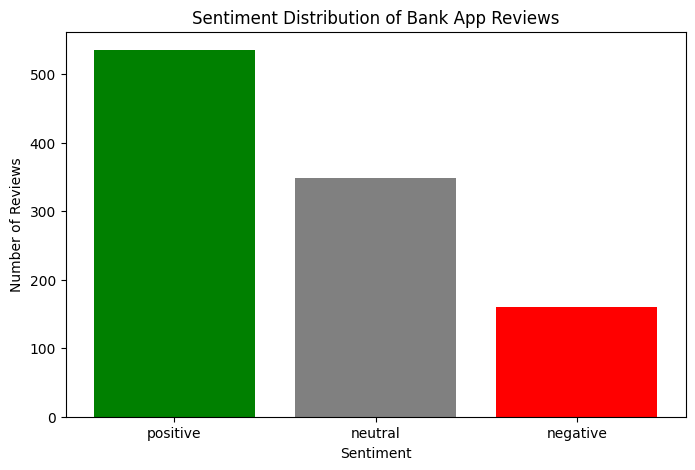

In [26]:
import matplotlib.pyplot as plt

# Counts of each sentiment
sentiment_counts = df_final['sentiment_label'].value_counts()

# Bar plot for sentiment distribution
plt.figure(figsize=(8,5))
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['green', 'gray', 'red'])
plt.title("Sentiment Distribution of Bank App Reviews")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()

bank_name
Bank of Abyssinia              362
Dashen Bank                    346
Commercial Bank of Ethiopia    335
Name: count, dtype: int64


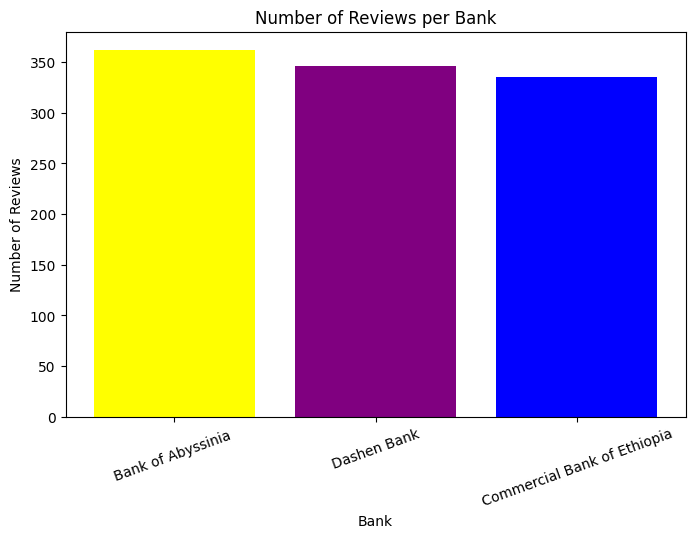

In [28]:
# review count per bank
review_counts = df_final['bank_name'].value_counts()
print(review_counts)
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(review_counts.index, review_counts.values, color=['yellow', 'purple', 'blue'])
plt.title("Number of Reviews per Bank")
plt.xlabel("Bank")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=20)
plt.show()



Sentiment Counts per Bank:
 sentiment_label              negative  neutral  positive
bank_name                                               
Bank of Abyssinia                  76      127       159
Commercial Bank of Ethiopia        32      133       170
Dashen Bank                        52       88       206


<Figure size 1000x500 with 0 Axes>

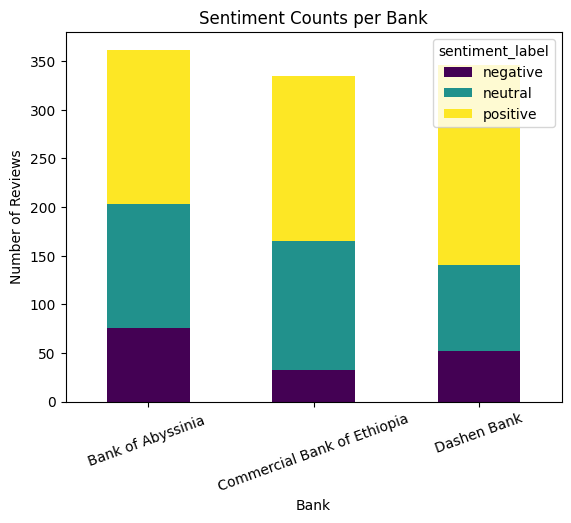

In [31]:
# Sentiment counts per bank
sentiment_per_bank = df_final.groupby('bank_name')['sentiment_label'].value_counts().unstack(fill_value=0)
print("\nSentiment Counts per Bank:\n", sentiment_per_bank)

# Plotting
plt.figure(figsize=(10,5))
sentiment_per_bank.plot(kind='bar', stacked=True, colormap='viridis')
plt.title("Sentiment Counts per Bank")
plt.xlabel("Bank")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=20)
plt.show()